In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F


/home/b106/anaconda3/envs/pytorch-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [3]:
# Load the CSV files
train_df = pd.read_csv('train_covid.csv')
test_df = pd.read_csv('test_covid.csv')


In [4]:
# Data preprocessing 
# Separate features and target variable from training data
X = train_df.drop(columns=['Prognosis'])
y = train_df['Prognosis']

# Convert target variable to binary
y = y.map({'MILD': 0, 'SEVERE': 1})

# Define categorical and numerical columns
categorical_cols = ['Hospital', 'Sex']
numerical_cols = [col for col in X.columns if col not in categorical_cols + ['Image']]

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)


In [5]:
# Define a deeper neural network model with batch normalization and dropout
class DeepNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc5(x))
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_preprocessed.shape[1]
model = DeepNN(input_dim).cuda()
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Function to train the model with cross-validation
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=30, fold=0):
    best_acc = 0.0
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * X_batch.size(0)
            correct_train += (torch.round(outputs) == y_batch.unsqueeze(1)).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        running_loss = 0.0
        correct_val = 0
        all_labels = []
        all_preds = []
        
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            with torch.no_grad():
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.unsqueeze(1))
                running_loss += loss.item() * X_batch.size(0)
                preds = torch.round(outputs)
                correct_val += (preds.squeeze() == y_batch).sum().item()
                all_labels.extend(y_batch.cpu().numpy())
                all_preds.extend(preds.squeeze().cpu().numpy())
        
        val_loss = running_loss / len(valid_loader.dataset)
        val_acc = correct_val / len(valid_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, f's1best_model_fold_{fold}.pt')
    
    model.load_state_dict(best_model_wts)
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies, all_labels, all_preds

# Function for cross-validation training
def cross_val_train(model, X, y, n_splits=5, num_epochs=30):
    best_acc = 0.0
    skf = StratifiedKFold(n_splits=n_splits)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{n_splits}")
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
        X_valid_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_val_fold, dtype=torch.float32)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
        
        model = DeepNN(input_dim).cuda()
        optimizer = optim.AdamW(model.parameters(), lr=0.001)
        
        model, train_losses, val_losses, train_accuracies, val_accuracies, val_labels, val_preds = train_model(
            model, train_loader, valid_loader, criterion, optimizer, num_epochs, fold)
        
        balanced_acc = balanced_accuracy_score(val_labels, val_preds)
        print(f"Fold {fold + 1} Balanced Accuracy: {balanced_acc}")
        
        fold_results.append((train_losses, val_losses, train_accuracies, val_accuracies))
        
        if balanced_acc > best_acc:
            best_acc = balanced_acc
    
    return model, best_acc, fold_results

# Train the model with cross-validation
trained_model, best_acc, fold_results = cross_val_train(model, X_preprocessed, y.values, num_epochs=30)
print(f"Best Balanced Accuracy from Cross-Validation: {best_acc}")


Fold 1/5
Epoch 0/29, Train Loss: 0.7264, Train Acc: 0.5000, Val Loss: 0.6794, Val Acc: 0.5894
Epoch 1/29, Train Loss: 0.6992, Train Acc: 0.5364, Val Loss: 0.6459, Val Acc: 0.6522
Epoch 2/29, Train Loss: 0.6374, Train Acc: 0.6723, Val Loss: 0.6235, Val Acc: 0.6425
Epoch 3/29, Train Loss: 0.5853, Train Acc: 0.7075, Val Loss: 0.5827, Val Acc: 0.6908
Epoch 4/29, Train Loss: 0.5570, Train Acc: 0.7124, Val Loss: 0.5866, Val Acc: 0.7053
Epoch 5/29, Train Loss: 0.5442, Train Acc: 0.7391, Val Loss: 0.5830, Val Acc: 0.7053
Epoch 6/29, Train Loss: 0.5170, Train Acc: 0.7561, Val Loss: 0.5184, Val Acc: 0.7150
Epoch 7/29, Train Loss: 0.4914, Train Acc: 0.7779, Val Loss: 0.5159, Val Acc: 0.7246
Epoch 8/29, Train Loss: 0.4874, Train Acc: 0.7718, Val Loss: 0.4992, Val Acc: 0.7295
Epoch 9/29, Train Loss: 0.4763, Train Acc: 0.7731, Val Loss: 0.5544, Val Acc: 0.7246
Epoch 10/29, Train Loss: 0.4771, Train Acc: 0.7670, Val Loss: 0.4940, Val Acc: 0.7246
Epoch 11/29, Train Loss: 0.4898, Train Acc: 0.7755, Val

Balanced Accuracy: 0.8918741808650066


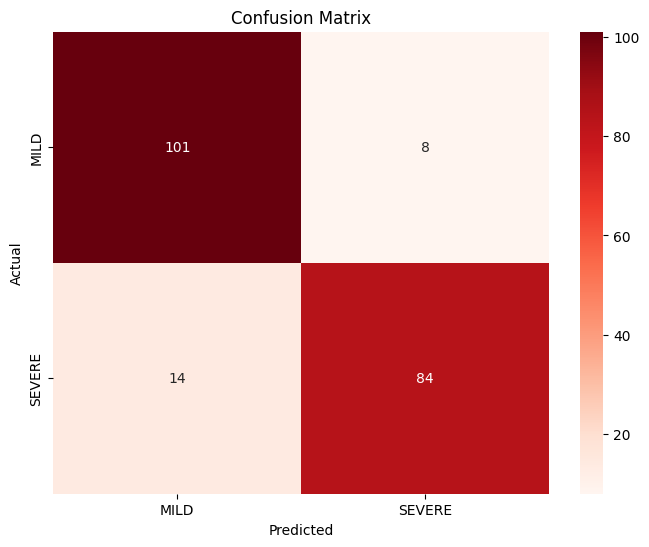

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90       109
         1.0       0.91      0.86      0.88        98

    accuracy                           0.89       207
   macro avg       0.90      0.89      0.89       207
weighted avg       0.89      0.89      0.89       207



In [6]:
# Evaluate the model
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_preprocessed, y, train_size=0.8, test_size=0.2, random_state=42)

# Convert validation data to PyTorch tensors
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).cuda()
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).cuda()

# Load the best model
best_model_path = 's1best_model_fold_0.pt'  # Adjust according to the best fold
model.load_state_dict(torch.load(best_model_path))

# Predict on validation data
model.eval()
with torch.no_grad():
    val_preds = model(X_valid_tensor)
    val_preds = torch.round(val_preds).cpu().numpy().flatten()

# Evaluate the model
balanced_acc = balanced_accuracy_score(y_valid_tensor.cpu().numpy(), val_preds)
print(f"Balanced Accuracy: {balanced_acc}")

# Confusion matrix
conf_matrix = confusion_matrix(y_valid_tensor.cpu().numpy(), val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['MILD', 'SEVERE'], yticklabels=['MILD', 'SEVERE'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_valid_tensor.cpu().numpy(), val_preds))


In [7]:
# Preprocess the test data
X_test_preprocessed = preprocessor.transform(test_df.drop(columns=['Image']))
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32).cuda()

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Predict on the test set
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_preds = torch.round(test_preds).cpu().numpy().flatten()  # Ensure predictions are 1-dimensional

# Create a submission dataframe
submission1 = pd.DataFrame({'Id': test_df['Image'], 'Prognosis': test_preds})
submission1['Prognosis'] = submission1['Prognosis'].map({0.0: 'MILD', 1.0: 'SEVERE'})
submission1.to_csv('mldl_competition4_Alargum_submission1.csv', index=False)

print("Submission file for Category 1 created successfully!")

print(submission1.head())


Submission file for Category 1 created successfully!
    Id Prognosis
0  657      MILD
1  212      MILD
2  108      MILD
3  666    SEVERE
4  861      MILD
